In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import datetime
from utils import stats_with_description, plot_time_range, make_features, customCV
from utils import winsorize_and_scale, tune_hyperparameters, GroupVariables, FeatureImportance
import re
import pickle
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
import copy

pd.set_option('display.max_columns', None)

C:\Users\Alessandro Bitetto\anaconda3\envs\wrds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set folders
CHECKPOINT_FOLDER = '.\\Checkpoints'
CODING_TABLES_FOLDER = '.\\Coding_tables'
STATS_FOLDER = '.\\Stats'
TUNING_FOLDER = '.\\Tuning'
TUNING_CHECKPOINT_FOLDER = '.\\Checkpoints\\Tuning'
GROUPVAR_CHECKPOINT_FOLDER = '.\\Checkpoints\\GroupingVariables'
FEATIMP_FOLDER = '.\\Feature_Importance'


if not os.path.exists(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)
if not os.path.exists(STATS_FOLDER):
    os.makedirs(STATS_FOLDER)
if not os.path.exists(TUNING_FOLDER):
    os.makedirs(TUNING_FOLDER)
if not os.path.exists(TUNING_CHECKPOINT_FOLDER):
    os.makedirs(TUNING_CHECKPOINT_FOLDER)
if not os.path.exists(GROUPVAR_CHECKPOINT_FOLDER):
    os.makedirs(GROUPVAR_CHECKPOINT_FOLDER)
if not os.path.exists(FEATIMP_FOLDER):
    os.makedirs(FEATIMP_FOLDER)

### Check years distribution

In [4]:
df_fundam_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_fundam_final.pkl'))

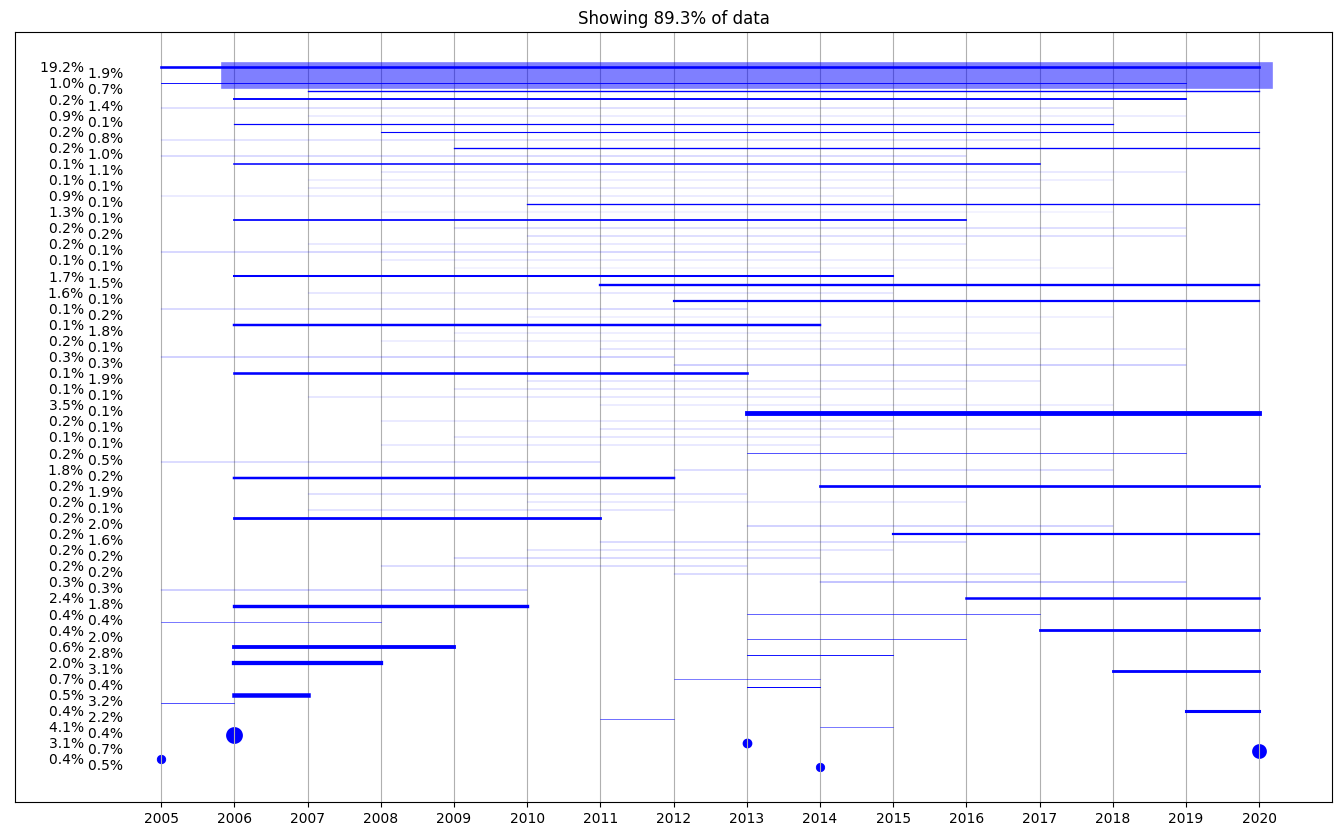

In [5]:
plot_time_range(df=df_fundam_final[df_fundam_final['consec_year_group'] != -1],
                gr_by=['gvkey', 'consec_year_group'], time_var='fyear', label_space=10)

# Replicate paper

*Predicting Future Earnings Changes Using Machine Learning and Detailed Financial Data*  https://onlinelibrary.wiley.com/doi/full/10.1111/1475-679X.12429

## Remove uninformative variables

In [107]:
FILE_NAME = 'df_paper'

# define dataset
df_work = (df_fundam_final[(~df_fundam_final['paper_period'].isna()) &
                           (df_fundam_final['consec_year_group'] != -1) &
                          (~df_fundam_final['LAG_index'].isna())]
          .drop(columns='fyear')
          .rename(columns={'paper_period_year': 'fyear'}))

# create features
df_work = make_features(df_work, df_original = df_fundam_final, thrsh_zeros = 0.3, file_name = FILE_NAME,
                        col_keep = ['main_index', 'fyear', 'EPS_change_next_yr', 'EPS_change_next_yr_detrend'], time_var = 'fyear',
                       CODING_TABLES_FOLDER=CODING_TABLES_FOLDER, STATS_FOLDER=STATS_FOLDER)

# stats
LIB = 'comp_na_annual_all'
TAB = 'funda'
df_work_stats = stats_with_description(df_work, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
df_work_stats.to_csv(os.path.join(STATS_FOLDER, '01a_' + FILE_NAME + '_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '01a_' + FILE_NAME + '_stats.csv'))

# save raw dataset for feature importance values
df_work.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_pred_'+FILE_NAME+'_raw.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_pred_'+FILE_NAME+'_raw.pkl'))



- Replacing missing values with zeros

- Removed columns because percentage of zeros is above 30.0 %: 385

- List of variables and percentages saved to .\Stats\01_df_paper_removed_col.csv
- Remaining columns: 135

- Evaluating lagged variables

- Evaluating percentage change
- Replacing NaN and Inf with zeros

- Normalizing by Total Asset
- Replacing Inf with zeros (some lagged total assets may be zero - only for oldest year available)

##### missing values found in:
   -EPS_change_next_yr_detrend: 3


,matched
2012.0,118
2013.0,1212
2014.0,1307
2015.0,1381
2016.0,1374
2017.0,1463
2018.0,1320
Total,8175



- Indices have been resetted

- Stats saved to .\Stats\01a_df_paper_stats.csv

- Pickle saved to .\Checkpoints\df_pred_df_paper_raw.pkl


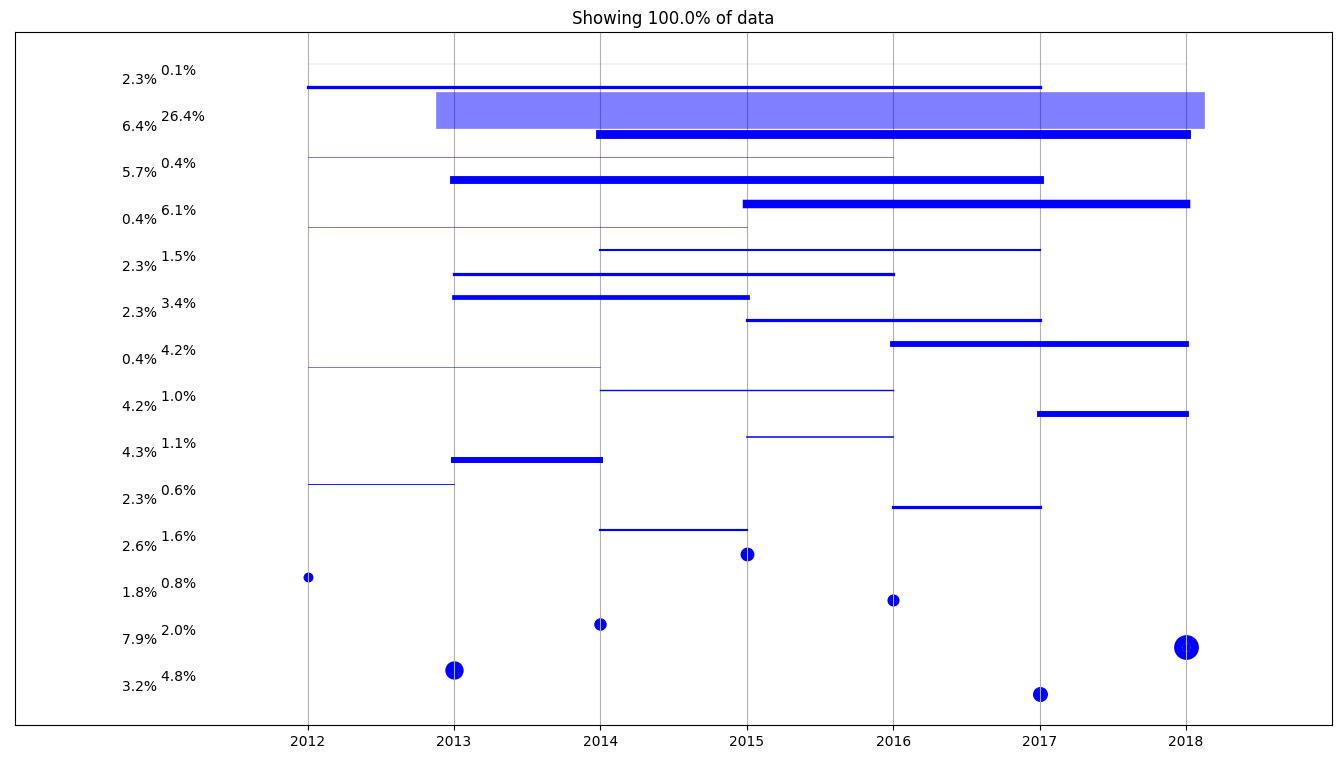

In [7]:
# check time interval

plot_time_range(df=(df_fundam_final.drop(columns=['fyear']).rename(columns={'paper_period_year': 'fyear'})
                    .merge(df_work[['main_index']].assign(cc = lambda x: 1), on='main_index', how='left')
                    .query('cc == 1')),
                gr_by=['gvkey', 'consec_year_group'], time_var='fyear', label_space=10, df_with_lagged_var=True,
                min_obs=0, min_count=0, fig_size=(17, 9))

## Define dataset

In [11]:
# Define final dataset, convert to binary flag, winsorize and scale
df_pred = df_work.copy()
df_pred['fyear'] = df_pred['fyear'].astype(int)
df_pred.index=df_pred['main_index']
df_pred=df_pred.drop(columns=['EPS_change_next_yr_detrend', 'main_index']).rename(columns={'EPS_change_next_yr': 'y'})
df_pred['y'] = np.where(df_pred['y'] > 0, 1, 0)

# winsorize and scale
df_pred=winsorize_and_scale(df_pred, skip_cols=['fyear', 'y'])
# stats
LIB = 'comp_na_annual_all'
TAB = 'funda'
df_pred_stats = stats_with_description(df_pred, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'),
                                       lag_label='_lag1', pc_label='_pc')
df_pred_stats.to_csv(os.path.join(STATS_FOLDER, '01b_' + FILE_NAME + '_scaled_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '01b_' + FILE_NAME + '_scaled_stats.csv'))

display(df_pred.head(5))

display(df_pred['y'].value_counts().to_frame().reset_index().rename(columns={'index': 'flag', 'y': 'count'}).assign(
        perc = lambda x: np.round(x['count'] / x['count'].sum() * 100, 2)))

display(df_pred.groupby('fyear').agg(**{
    'Tot Obs': ('y', 'size'),
    '1': ('y', lambda x: str(sum(x == 1)) + ' (' + str(np.round(sum(x == 1) / len(x) * 100, 1)) +'%)' ),
    '0': ('y', lambda x: str(sum(x == 0)) + ' (' + str(np.round(sum(x == 0) / len(x) * 100, 1)) +'%)' )}))

df_pred.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_pred_'+FILE_NAME+'.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_pred_'+FILE_NAME+'.pkl'))


- Stats saved to .\Stats\01b_df_paper_scaled_stats.csv


,fyear,y,ni,pi,csho,ebit,cshfd,ibc,citotal,seq,lse,teq,oiadp,ivncf,icapt,cshpri,dilavx,at,ibcom,ibadj,niadj,ci,ib,cibegni,oancf,ceq,xopr,fincf,chech,lt,ceqt,opeps,bkvlps,che,epspi,epsfx,epsfi,ceql,epspx,oprepsx,gp,cshi,revt,fopo,sale,cogs,ao,aoloch,rect,re,stkco,emp,ch,ap,lo,oibdp,ebitda,txt,ibmii,dpc,cshr,fopox,dp,reuna,cstk,ppent,capx,cstkcv,aox,txpd,txndb,nopi,aodo,caps,lco,rectr,capxv,xrent,intpn,loxdr,ppegt,dpact,ppeveb,mrc1,txndba,recch,txdi,txndbl,intan,acominc,mrc2,dpvieb,mrc3,xint,aco,nopio,mrct,mrc4,dltt,xsga,xpr,txdc,optosey,act,wcap,lct,optosby,spi,intano,optprcey,optprcby,txc,mrc5,acox,gdwl,optex,lcox,mrcta,acodo,dt,optprcwa,sstk,dltr,fiao,optexd,optprcex,txs,xacc,ivaco,dlc,am,tfva,optca,optprcca,txtubend,txtubbegin,txfed,ni_lag1,pi_lag1,csho_lag1,ebit_lag1,cshfd_lag1,ibc_lag1,citotal_lag1,seq_lag1,lse_lag1,teq_lag1,oiadp_lag1,ivncf_lag1,icapt_lag1,cshpri_lag1,dilavx_lag1,at_lag1,ibcom_lag1,ibadj_lag1,niadj_lag1,ci_lag1,ib_lag1,cibegni_lag1,oancf_lag1,ceq_lag1,xopr_lag1,fincf_lag1,chech_lag1,lt_lag1,ceqt_lag1,opeps_lag1,bkvlps_lag1,che_lag1,epspi_lag1,epsfx_lag1,epsfi_lag1,ceql_lag1,epspx_lag1,oprepsx_lag1,gp_lag1,cshi_lag1,revt_lag1,fopo_lag1,sale_lag1,cogs_lag1,ao_lag1,aoloch_lag1,rect_lag1,re_lag1,stkco_lag1,emp_lag1,ch_lag1,ap_lag1,lo_lag1,oibdp_lag1,ebitda_lag1,txt_lag1,ibmii_lag1,dpc_lag1,cshr_lag1,fopox_lag1,dp_lag1,reuna_lag1,cstk_lag1,ppent_lag1,capx_lag1,cstkcv_lag1,aox_lag1,txpd_lag1,txndb_lag1,nopi_lag1,aodo_lag1,caps_lag1,lco_lag1,rectr_lag1,capxv_lag1,xrent_lag1,intpn_lag1,loxdr_lag1,ppegt_lag1,dpact_lag1,ppeveb_lag1,mrc1_lag1,txndba_lag1,recch_lag1,txdi_lag1,txndbl_lag1,intan_lag1,acominc_lag1,mrc2_lag1,dpvieb_lag1,mrc3_lag1,xint_lag1,aco_lag1,nopio_lag1,mrct_lag1,mrc4_lag1,dltt_lag1,xsga_lag1,xpr_lag1,txdc_lag1,optosey_lag1,act_lag1,wcap_lag1,lct_lag1,optosby_lag1,spi_lag1,intano_lag1,optprcey_lag1,optprcby_lag1,txc_lag1,mrc5_lag1,acox_lag1,gdwl_lag1,optex_lag1,lcox_lag1,mrcta_lag1,acodo_lag1,dt_lag1,optprcwa_lag1,sstk_lag1,dltr_lag1,fiao_lag1,optexd_lag1,optprcex_lag1,txs_lag1,xacc_lag1,ivaco_lag1,dlc_lag1,am_lag1,tfva_lag1,optca_lag1,optprcca_lag1,txtubend_lag1,txtubbegin_lag1,txfed_lag1,ni_pc,pi_pc,csho_pc,ebit_pc,cshfd_pc,ibc_pc,citotal_pc,seq_pc,lse_pc,teq_pc,oiadp_pc,ivncf_pc,icapt_pc,cshpri_pc,dilavx_pc,at_pc,ibcom_pc,ibadj_pc,niadj_pc,ci_pc,ib_pc,cibegni_pc,oancf_pc,ceq_pc,xopr_pc,fincf_pc,chech_pc,lt_pc,ceqt_pc,opeps_pc,bkvlps_pc,che_pc,epspi_pc,epsfx_pc,epsfi_pc,ceql_pc,epspx_pc,oprepsx_pc,gp_pc,cshi_pc,revt_pc,fopo_pc,sale_pc,cogs_pc,ao_pc,aoloch_pc,rect_pc,re_pc,stkco_pc,emp_pc,ch_pc,ap_pc,lo_pc,oibdp_pc,ebitda_pc,txt_pc,ibmii_pc,dpc_pc,cshr_pc,fopox_pc,dp_pc,reuna_pc,cstk_pc,ppent_pc,capx_pc,cstkcv_pc,aox_pc,txpd_pc,txndb_pc,nopi_pc,aodo_pc,caps_pc,lco_pc,rectr_pc,capxv_pc,xrent_pc,intpn_pc,loxdr_pc,ppegt_pc,dpact_pc,ppeveb_pc,mrc1_pc,txndba_pc,recch_pc,txdi_pc,txndbl_pc,intan_pc,acominc_pc,mrc2_pc,dpvieb_pc,mrc3_pc,xint_pc,aco_pc,nopio_pc,mrct_pc,mrc4_pc,dltt_pc,xsga_pc,xpr_pc,txdc_pc,optosey_pc,act_pc,wcap_pc,lct_pc,optosby_pc,spi_pc,intano_pc,optprcey_pc,optprcby_pc,txc_pc,mrc5_pc,acox_pc,gdwl_pc,optex_pc,lcox_pc,mrcta_pc,acodo_pc,dt_pc,optprcwa_pc,sstk_pc,dltr_pc,fiao_pc,optexd_pc,optprcex_pc,txs_pc,xacc_pc,ivaco_pc,dlc_pc,am_pc,tfva_pc,optca_pc,optprcca_pc,txtubend_pc,txtubbegin_pc,txfed_pc
main_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.0,2015,1,0.033077,0.041121,0.023934,0.045836,0.023993,0.028084,0.030303,0.600374,1.0,0.600374,0.045836,-0.011719,0.694751,0.023854,0.027737,0.315900,0.028084,0.027737,0.032730,0.030303,0.028084,0.033077,0.022259,0.600374,0.105797,-0.026628,-0.016296,0.039963,0.483462,0.007628,0.173

,flag,count,perc
0,1,4660,57.0
1,0,3515,43.0


,Tot Obs,1,0
fyear,,,
2012,118,61 (51.7%),57 (48.3%)
2013,1212,706 (58.3%),506 (41.7%)
2014,1307,737 (56.4%),570 (43.6%)
2015,1381,690 (50.0%),691 (50.0%)
2016,1374,802 (58.4%),572 (41.6%)
2017,1463,835 (57.1%),628 (42.9%)
2018,1320,829 (62.8%),491 (37.2%)



- Pickle saved to .\Checkpoints\df_pred_df_paper.pkl


## Tune ML models

In [4]:
FILE_NAME = 'df_paper'
df_pred = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_pred_'+FILE_NAME+'.pkl'))

In [4]:
TOT_TRIALS = 150
MEASURE = f1_score
CV_ITERATOR = customCV(n_train_years=2, n_test_years=1, rolling_wind_step=1, train_test_offset=0,
                       year_variable='fyear', back_ward=False, show_info=False)
OUT_OF_SAMPLE_YEARS = 1
TIME_VAR = 'fyear'
ADD_MEASURE = [roc_auc_score, accuracy_score, precision_score, recall_score]
OPTIM_MEASURE = 'valid_best'    # find best hyperparameters according to validation score (best means with optimized threshold)

RELOAD = True

In [10]:
# loop over models

for mod in ['ElasticNet', 'RandomForest', 'LightGBM']:
    
    print('#'*(70+len(mod)+4))
    print('#'+' '*35, mod, ' '*35+'#')
    print('#'*(70+len(mod)+4),'\n\n')
    _, _=tune_hyperparameters(df=df_pred, tot_trials=TOT_TRIALS, model_type=mod, measure=MEASURE, cv_iterator=CV_ITERATOR,
                              time_var=TIME_VAR, out_of_sample_years=OUT_OF_SAMPLE_YEARS, add_measure=ADD_MEASURE,
                              optim_measure=OPTIM_MEASURE, file_name=FILE_NAME, tuning_folder=TUNING_FOLDER,
                              tuning_checkpoint_folder=TUNING_CHECKPOINT_FOLDER, reload=RELOAD)
    print('\n\n')

####################################################################################
#                                    ElasticNet                                    #
#################################################################################### 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


- Started at: 15/12/2022 22:26:25 

Trial 150 / 150     avg elapsed time:  0:00:07   current optimal value: 0.7193248209007967                               
Total elapsed time: 0:17:33


- Pickle saved to .\Tuning\df_paper_ElasticNet_f1_score.pkl


Optimization metric: f1_score on valid_best
Optimal score: 0.7193248209007967   (Trial 89)
Best pa

,Performance,best_thresh,train_best,valid_best,test_best,train_05,valid_05,test_05
89,F1,0.086,0.726902,0.719325,0.729260,0.704909,0.602994,0.629448
89,ROC_AUC,,0.754928,0.604131,0.644680,,,
89,ACCURACY,0.086,0.584802,0.572839,0.585211,0.683793,0.572643,0.600948
89,PRECISION,0.086,0.572843,0.565759,0.579579,0.729869,0.619872,0.66777
89,RECALL,0.086,0.995474,0.989797,0.985856,0.681652,0.588649,0.598714



- Tuning log saved to .\Tuning\df_paper_ElasticNet_f1_score.csv



######################################################################################
#                                    RandomForest                                    #
###################################################################################### 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


- Started at: 15/12/2022 22:44:16 

Trial 150 / 150     avg elapsed time:  0:01:53   current optimal value: 0.7201873689010729                               
Total elapsed time: 11:13:52


- Pickle saved to .\Tuning\df_paper_RandomForest_f1_score.pkl


Optimization metric: 

,Performance,best_thresh,train_best,valid_best,test_best,train_05,valid_05,test_05
133,F1,0.259,0.725917,0.720187,0.732697,0.782611,0.629931,0.648522
133,ROC_AUC,,0.827409,0.628667,0.655820,,,
133,ACCURACY,0.259,0.582889,0.574058,0.592301,0.76162,0.594734,0.60884
133,PRECISION,0.259,0.571557,0.566669,0.588038,0.794538,0.639121,0.667864
133,RECALL,0.259,0.995286,0.990803,0.981882,0.7711,0.623832,0.6359



- Tuning log saved to .\Tuning\df_paper_RandomForest_f1_score.csv



##################################################################################
#                                    LightGBM                                    #
################################################################################## 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


- Started at: 16/12/2022 09:59:01 

Trial 150 / 150     avg elapsed time:  0:00:09   current optimal value: 0.72233628783013                                 
Total elapsed time: 0:27:38


- Pickle saved to .\Tuning\df_paper_LightGBM_f1_score.pkl


Optimization metric: f1_score on val

,Performance,best_thresh,train_best,valid_best,test_best,train_05,valid_05,test_05
107,F1,0.227,0.999574,0.722336,0.735459,1.0,0.664731,0.678091
107,ROC_AUC,,1.000000,0.631097,0.664378,,,
107,ACCURACY,0.227,0.999542,0.589967,0.608591,1.0,0.603456,0.618932
107,PRECISION,0.227,0.999148,0.578691,0.600256,1.0,0.628027,0.658418
107,RECALL,0.227,1.000000,0.964135,0.957162,1.0,0.712615,0.706957



- Tuning log saved to .\Tuning\df_paper_LightGBM_f1_score.csv





## Feature Importance

In [4]:
FILE_NAME = 'df_paper'
df_pred = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_pred_'+FILE_NAME+'.pkl'))

### Select subset of features

#### Evaluate distance correlation

- Distance matrix reloaded from .\Checkpoints\GroupingVariables\df_paper_dist_mat.pkl


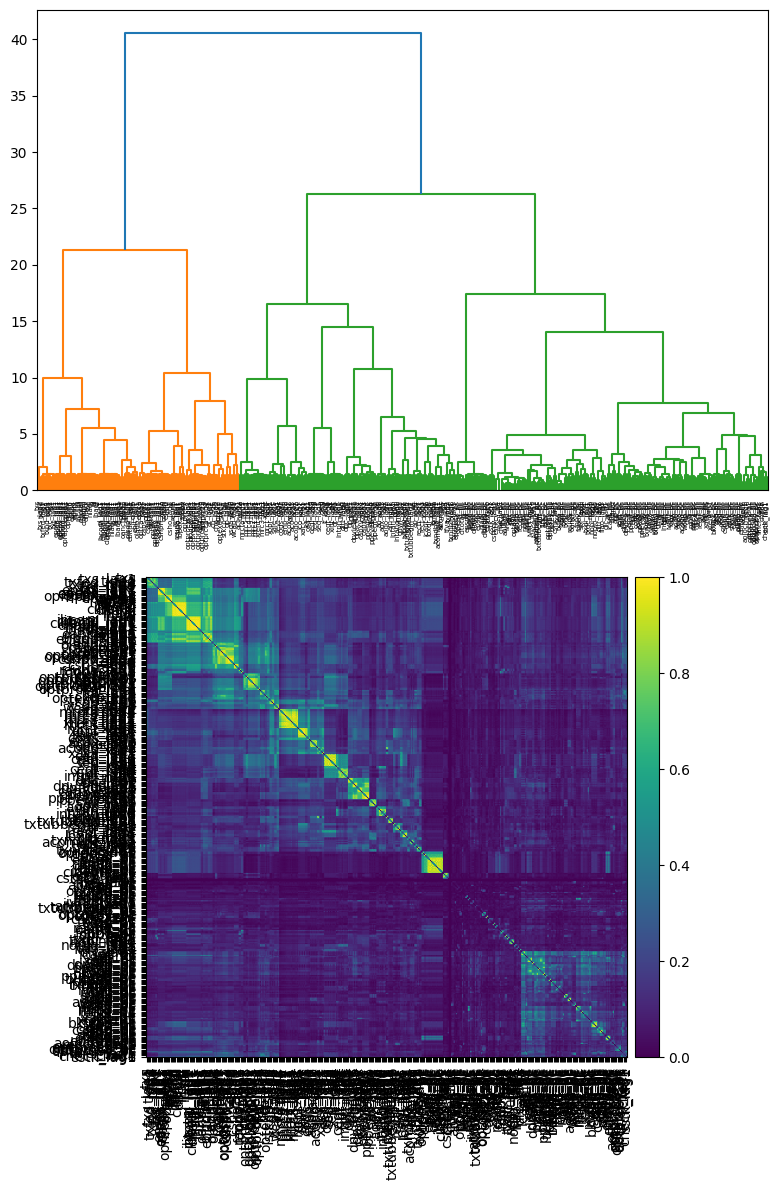

In [6]:
TIME_VAR = 'fyear'
VAR_DESCRIPTION = '01b_df_paper_scaled_stats.csv'    # used to extract variables description. Must be in STATS_FOLDER
RELOAD_MAT = True              # reload distance matrix of variables (distance correlation)

gv=GroupVariables(df=df_pred, time_var=TIME_VAR, n_jobs=-1, file_name=FILE_NAME, var_description=VAR_DESCRIPTION,
                  stats_folder=STATS_FOLDER, checkpoint_folder=CHECKPOINT_FOLDER, tuning_folder=TUNING_FOLDER,
                  groupvar_folder=GROUPVAR_CHECKPOINT_FOLDER, featimp_folder=FEATIMP_FOLDER)

gv.evaluate_distance(reload=RELOAD_MAT)

gv.plot_dendro(fig_size=(8, 12))

#### Evaluate performance for each group

In [7]:
FIND_CLUSTER_RANGE = [20, 60]     # range of number of clusters to be tested for grouping variables
MODEL_TYPE = 'LightGBM'           # model used to evaluate performance on subset of variables
RELOAD_CLUSTER = True             # reload performance on each tested cluster

gv.test_variables_groups(model_type=MODEL_TYPE, find_cluster_range=FIND_CLUSTER_RANGE, reload=RELOAD_CLUSTER)


- Testing different number of groups for all variables - Started at: 02/02/2023 16:49:53
   Grouping in 60 clusters (41/41)    Last update at: 16:49:54
   Elapsed time: 0:00:01

- Cluster pickle saved to .\Checkpoints\GroupingVariables\df_paper_dist_mat_cluster_variables.pkl


,Model,Performance,best_thresh,valid_best,diff
0,All variables,F1,0.227,0.722336,
0,60 cluster,F1,0.235,0.720145,-0.002192
0,20 cluster,F1,0.161,0.718780,-0.003556
0,22 cluster,F1,0.160,0.718755,-0.003581
0,23 cluster,F1,0.144,0.718497,-0.003839
0,34 cluster,F1,0.159,0.718009,-0.004328
0,25 cluster,F1,0.184,0.717958,-0.004378
0,24 cluster,F1,0.172,0.717739,-0.004597
0,21 cluster,F1,0.183,0.717662,-0.004675
0,27 cluster,F1,0.155,0.717633,-0.004703


#### Select number of groups of variables

In [13]:
NUM_CLUSTER=20     # groups of variables to keep

best_variables = gv.select_groups(num_cluster=NUM_CLUSTER, save_prefix='01c_')


- 20 groups of variables selected:

   'txpd': TXPD -- Income Taxes Paid (TXPD)
   'epspi': EPSPI -- Earnings Per Share (Basic) Including Extraordinary Items (EPSPI)
   'ibcom': IBCOM -- Income Before Extraordinary Items Available for Common (IBCOM)
   'ebit': EBIT -- Earnings Before Interest and Taxes (EBIT)
   'fopox': FOPOX -- Funds from Operations - Other excluding Option Tax Benefit (FOPOX)
   'at': AT -- Assets - Total (AT)
   'optexd_lag1': Lag of OPTEXD -- Options - Exercised (-) (OPTEXD)
   'mrcta_lag1': Lag of MRCTA -- Thereafter Portion of Leases (MRCTA)
   'revt': REVT -- Revenue - Total (REVT)
   'xacc_lag1': Lag of XACC -- Accrued Expenses (XACC)
   'teq': TEQ -- Stockholders Equity - Total (TEQ)
   'intpn': INTPN -- Interest Paid Net (INTPN)
   'capx': CAPX -- Capital Expenditures (CAPX)
   'aodo': AODO -- Other Assets excluding Discontinued Operations (AODO)
   'txndb': TXNDB -- Net Deferred Tax Asset (Liab) - Total (TXNDB)
   'ibc_pc': Percentage change of IBC -- Incom

#### Train model with best variables

In [165]:
RELOAD_TRAIN = False

# you can also define the variables to use with
# SELECT_VARIABLES=['txpd', 'epspi', 'ibcom', 'ebit', 'fopox', 'at', 'optexd_lag1', 'mrcta_lag1', 'revt',
#                   'xacc_lag1', 'teq', 'intpn', 'capx', 'aodo', 'txndb', 'ibc_pc', 'spi', 'icapt_pc', 'ivncf', 'optprcby_pc']
SELECT_VARIABLES=[]

gv.train_model(reload=RELOAD_TRAIN, select_variables=SELECT_VARIABLES)

- Fitted model F1: 0.719

- Fitted model pickle saved to .\Feature_Importance\df_paper_LightGBM_model_for_explainer.pkl


### Evaluate SHAP feature importance

#### Evaluate SHAP values

In [32]:
fi.shap_log['split_0']['shap_values'].feature_names

['txpd',
 'epspi',
 'ibcom',
 'ebit',
 'fopox',
 'at',
 'optexd_lag1',
 'mrcta_lag1',
 'revt',
 'xacc_lag1',
 'teq',
 'intpn',
 'capx',
 'aodo',
 'txndb',
 'ibc_pc',
 'spi',
 'icapt_pc',
 'ivncf',
 'optprcby_pc']

In [5]:
# change name for variable
VAR_DISPLAY_NAME={
    'txpd': 'Income Taxes Paid',
    'epspi': 'Earnings Per Share',
    'ibcom': 'Income Before Extraordinary\nItems Available for Common',
    'ebit': 'EBIT',
    'fopox': 'Funds from Operations\nOther excluding Option\nTax Benefit',
    'at': 'Total Assets',
    'optexd_lag1': 'Lag of Exercised Options',
    'mrcta_lag1': 'Lag of Thereafter\nPortion of Leases',
    'revt': 'Total Revenue',
    'xacc_lag1': 'Lag of Accrued Expenses',
    'teq': 'Stockholders Equity',
    'intpn': 'Interest Paid Net',
    'capx': 'Capital Expenditures',
    'aodo': 'Other Assets excluding\nDiscontinued Operations',
    'txndb': 'Total Net Deferred\nTax Asset (Liab)',
    'ibc_pc': 'Percentage change of Income\nBefore Extraordinary Items',
    'spi': 'Special Items',
    'icapt_pc': 'Percentage change of\nTotal Invested Capital',
    'ivncf': 'Investing Activities\nNet Cash Flow',
    'optprcby_pc': 'Percentage change of Options\nOutstanding Beg of Year',
}

In [7]:
MODEL_TYPE = 'LightGBM'
RELOAD_FEATIMP=False

df_pred_raw = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_pred_'+FILE_NAME+'_raw.pkl'))
fi=FeatureImportance(df=df_pred, df_orig=df_pred_raw, var_display_name=VAR_DISPLAY_NAME,
                     file_name=FILE_NAME, featimp_folder=FEATIMP_FOLDER)

fi.eval_shap_values(model_type='LightGBM', reload=RELOAD_FEATIMP)

- Evaluating SHAP on: 2015 (1381 obs)


 95%|=================== | 1312/1381 [00:23<00:01]       

- Evaluating SHAP on: 2016 (1374 obs)


 99%|===================| 1360/1374 [00:26<00:00]        

- Evaluating SHAP on: 2017 (1463 obs)


 99%|===================| 1452/1463 [00:27<00:00]        

- Evaluating SHAP on: 2018 (1320 obs)


100%|===================| 1319/1320 [00:24<00:00]        


- SHAP values pickle saved to .\Feature_Importance\df_paper_LightGBM_shap_values.pkl


#### Plot average absolute SHAP feature importance

- Plot saved in .\Feature_Importance



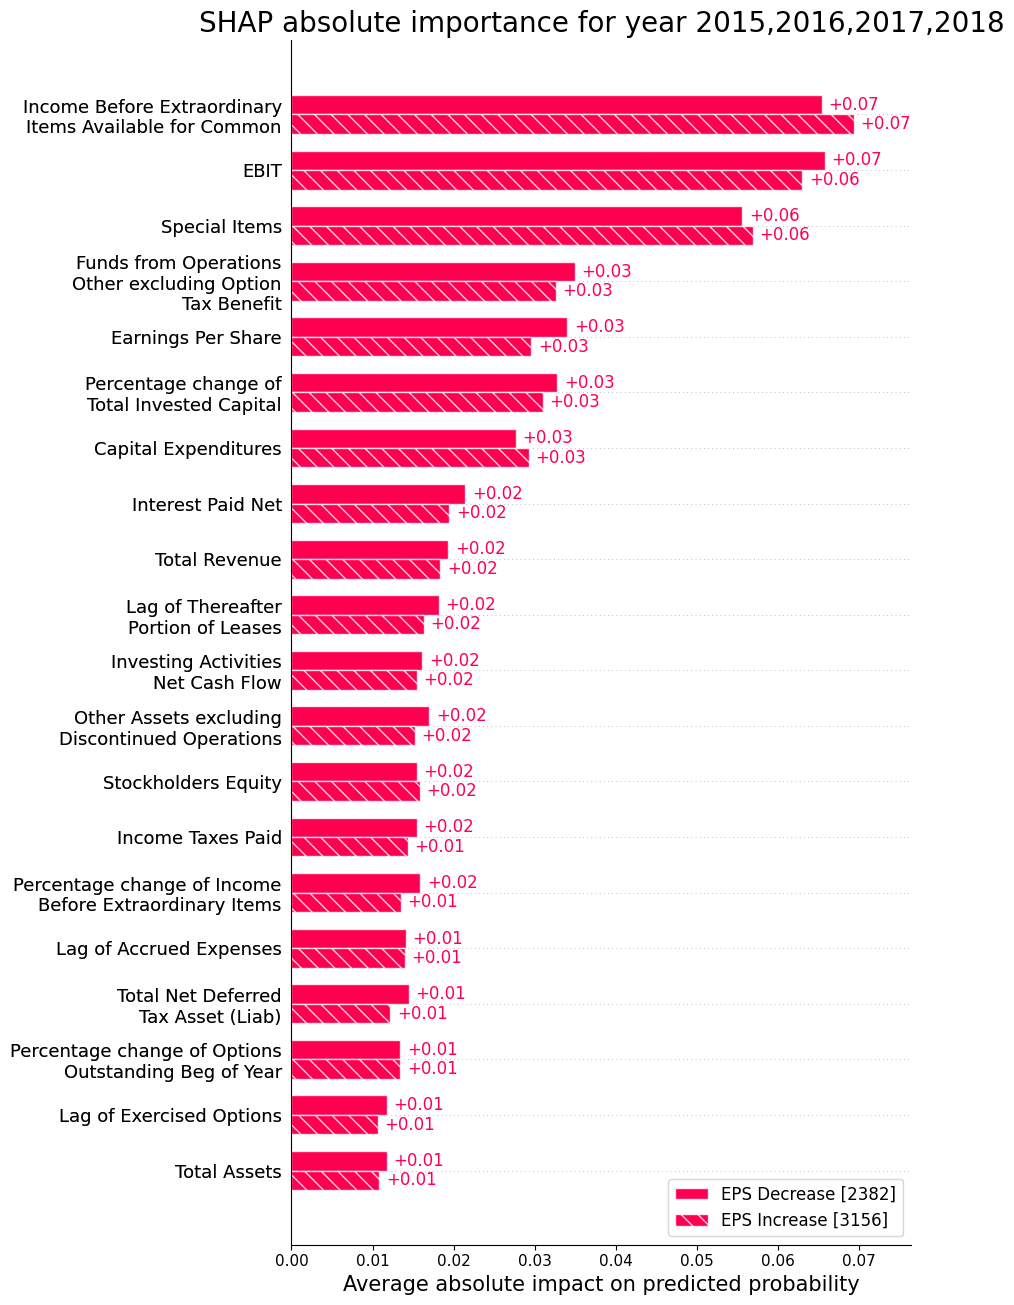

In [9]:
fi.plot_bar()

#### Plot SHAP impact on prections

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


- Plot saved in .\Feature_Importance



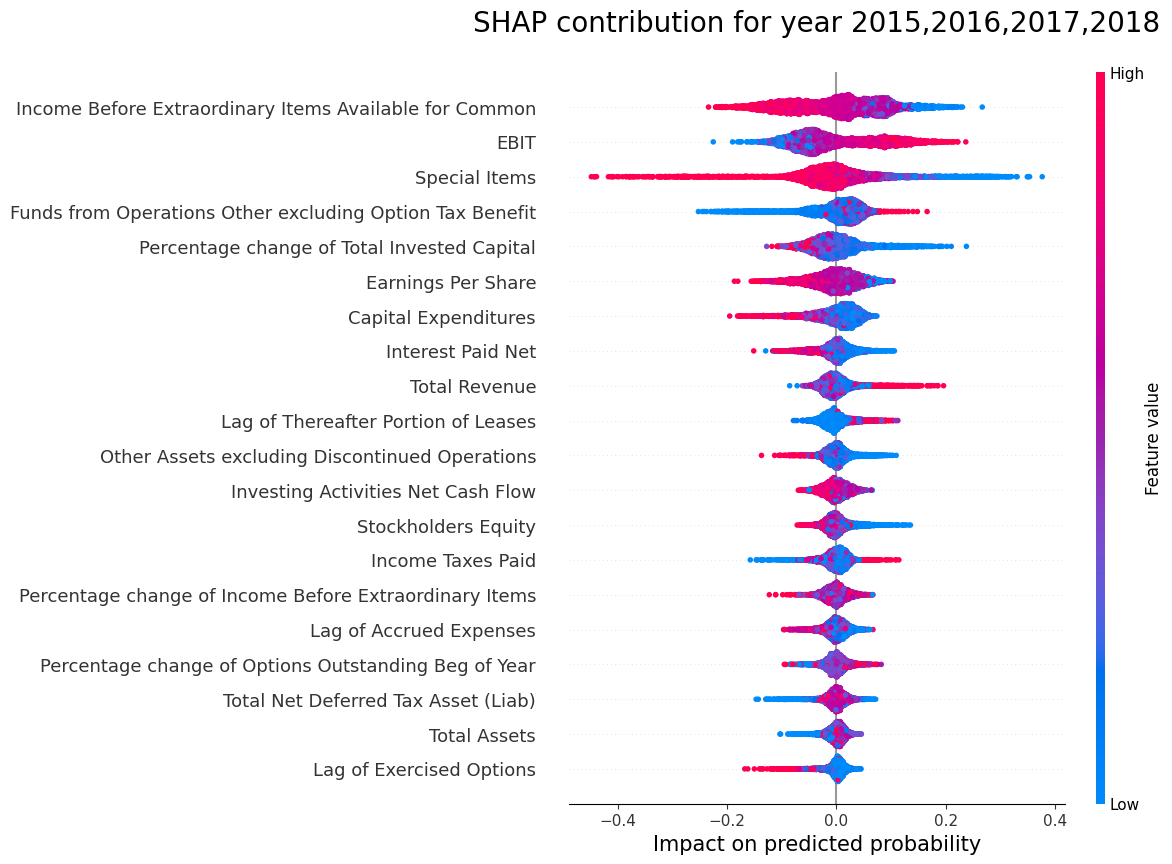

In [10]:
fi.plot_swarm()

#### Plot SHAP interactions

- Plot saved in .\Feature_Importance



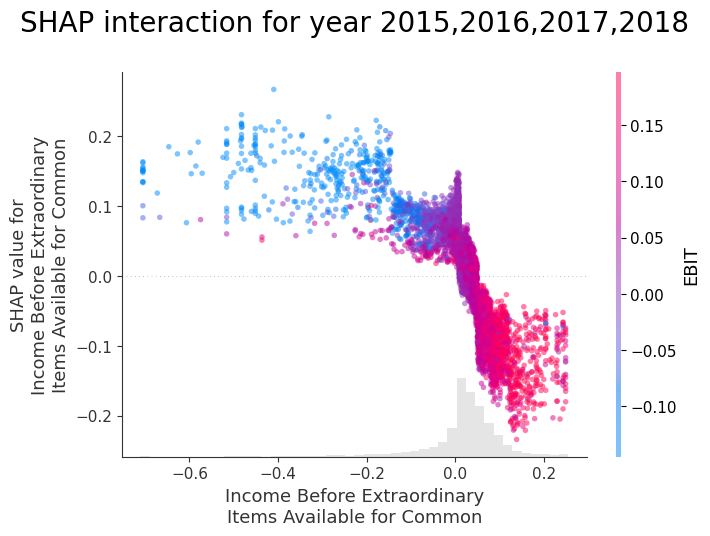

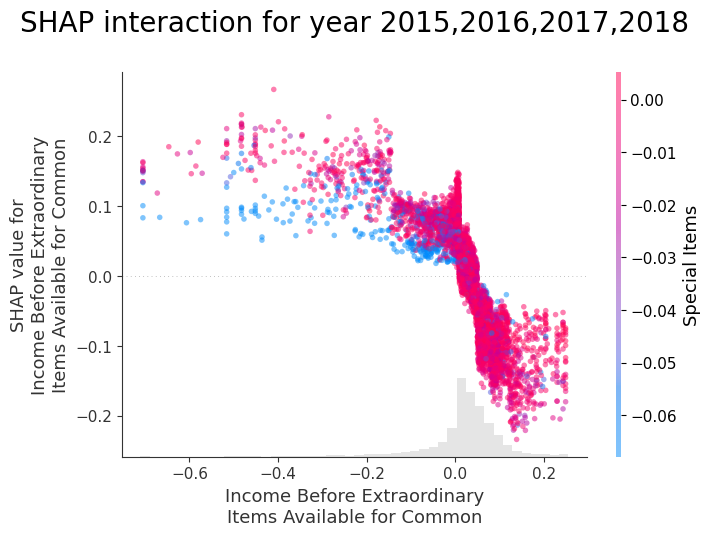

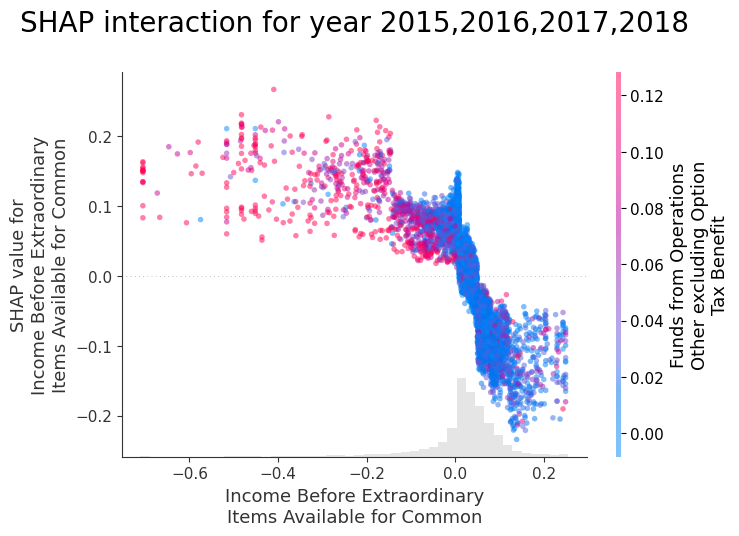

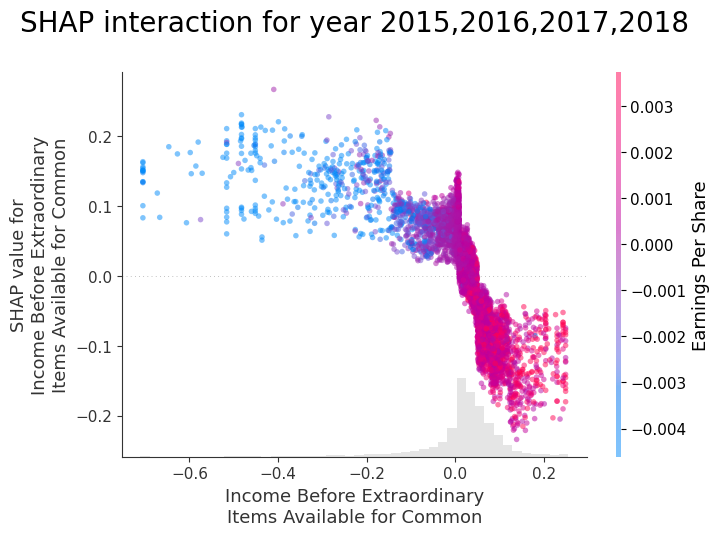

In [20]:
CUSTOM_FEATURES=['ibcom', 'ebit', 'spi', 'fopox', 'epspi']

fi.plot_interactions(custom_features=CUSTOM_FEATURES, multirow_label=True, alpha=0.5)